This notebook present the steps to generate merged catalog files. The reason that we need to generate such files is that:

1. Bliss needs input parameters that contains psf, fluxes, location, source type, galaxy related parameters, but the truth catalog in DC2 does not provide galaxy parameters or psf
2. To get those parameter, we need to use CosmoDC2 dataset and truth-match table, where the galaxy parameters and psf are stored.
3. To save the time for multiple merging when loading the data, we store the merged dataset into corresponding merged_catalog_{}.pkl files

### Load Catalog

Use [GCRCatalogs](https://data.lsstdesc.org/doc/install_gcr) package to load the dc2 truth catalog and CosomoDC2.




In [1]:
import pickle
import GCRCatalogs
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd

In [2]:
output_dir = Path("./generate_catalog_output/")
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
truth_catalog_pickle_file = output_dir / "truth_catalog.pkl"
GCRCatalogs.set_root_dir("/nfs/turbo/lsa-regier/lsstdesc-public/dc2")
if truth_catalog_pickle_file.exists():
    with open(truth_catalog_pickle_file, "rb") as inputp: 
        truth_cat_data = pickle.load(inputp)
else:   
    truth_cat = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_truth") 
    truth_cat_data = truth_cat.get_quantities([
        "id", "match_objectId", "cosmodc2_id", "ra", "dec", "truth_type", 
        "flux_g", "flux_i", "flux_r", "flux_u", "flux_y", "flux_z"
    ])
    with open(truth_catalog_pickle_file, "wb") as outp:
        pickle.dump(truth_cat_data, outp, pickle.HIGHEST_PROTOCOL)

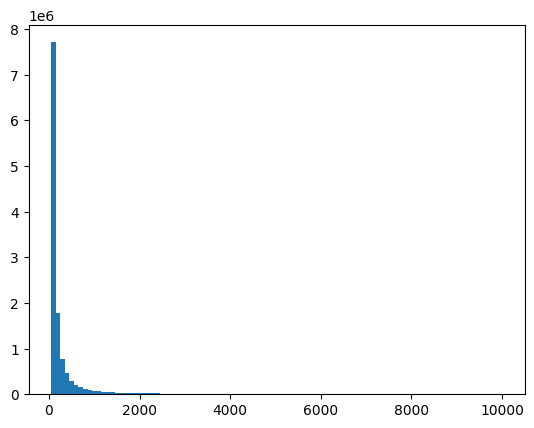

In [4]:
plt.hist(truth_cat_data["flux_r"], np.linspace(50, 10000, num=100))
plt.show()

In [5]:
galaxy_params_pickle_file = output_dir / "galaxy_params.pkl"
if galaxy_params_pickle_file.exists():
    with open(galaxy_params_pickle_file, "rb") as inputp: 
        galaxy_params_data = pickle.load(inputp)
else:
    galaxy_params = GCRCatalogs.load_catalog("desc_cosmodc2", {
        "catalog_root_dir": "/nfs/turbo/lsa-regier/lsstdesc-public/dc2/cosmoDC2",
    })
    galaxy_params_data = galaxy_params.get_quantities([
        "galaxy_id", "position_angle_true", "size_minor_disk_true", 
        "size_disk_true", "size_minor_bulge_true", 
        "size_bulge_true", "bulge_to_total_ratio_i"
    ])
    with open(galaxy_params_pickle_file, "wb") as outp:
        pickle.dump(galaxy_params_data, outp, pickle.HIGHEST_PROTOCOL)

In [6]:
psf_params_pickle_file = output_dir / "psf_params.pkl"
if psf_params_pickle_file.exists():
    with open(psf_params_pickle_file, "rb") as inputp: 
        psf_params_data = pickle.load(inputp)
else:
    psf_params = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
    psf_params_data = psf_params.get_quantities([
        "objectId",
        "IxxPSF_pixel_g", "IxxPSF_pixel_z", 
        "IxxPSF_pixel_r", "IxxPSF_pixel_i", "IxxPSF_pixel_u", 
        "IxxPSF_pixel_y", "IyyPSF_pixel_g", "IyyPSF_pixel_z", 
        "IyyPSF_pixel_r", "IyyPSF_pixel_i", "IyyPSF_pixel_u", 
        "IyyPSF_pixel_y", "IxyPSF_pixel_g", "IxyPSF_pixel_z", 
        "IxyPSF_pixel_r", "IxyPSF_pixel_i", "IxyPSF_pixel_u", 
        "IxyPSF_pixel_y", "psf_fwhm_g", "psf_fwhm_z", "psf_fwhm_r",
        "psf_fwhm_i", "psf_fwhm_u", "psf_fwhm_y"
    ])
    with open(psf_params_pickle_file, "wb") as outp:
        pickle.dump(psf_params_data, outp, pickle.HIGHEST_PROTOCOL)

### Merge Catalog 

In [7]:
merged_catalog_pikle_file = output_dir / "merged_catalog.pkl"
if merged_catalog_pikle_file.exists():
    with open(merged_catalog_pikle_file, "rb") as inputp: 
        truth_galaxy_psf_df = pickle.load(inputp)
else:
    truth_cat_df = pd.DataFrame(truth_cat_data)
    galaxy_params_df = pd.DataFrame(galaxy_params_data)
    psf_params_df = pd.DataFrame(psf_params_data)
    truth_galaxy_df = truth_cat_df.merge(
        galaxy_params_df, 
        left_on="cosmodc2_id", 
        right_on="galaxy_id", 
        how="left" 
    )
    truth_galaxy_psf_df = truth_galaxy_df.fillna(-1).merge(
        psf_params_df, 
        left_on="match_objectId", 
        right_on="objectId", 
        how="left" 
    )
    with open(merged_catalog_pikle_file, "wb") as outp:
        pickle.dump(truth_galaxy_psf_df, outp, pickle.HIGHEST_PROTOCOL)

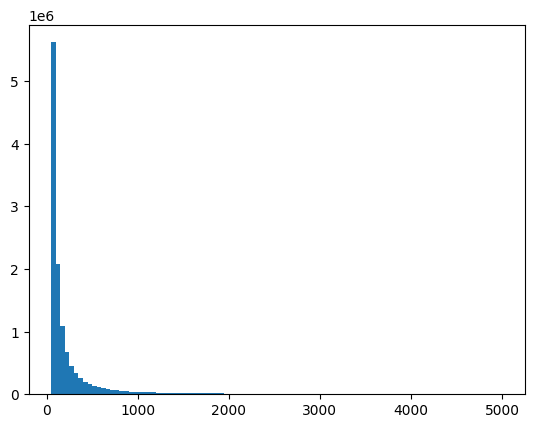

In [8]:
# filter the object by flux
flux_min = 50
truth_galaxy_psf_df = truth_galaxy_psf_df.loc[truth_galaxy_psf_df["flux_r"] > flux_min]
plt.hist(truth_galaxy_psf_df["flux_r"], np.linspace(flux_min, flux_min * 100, num=100))
plt.show()

### Save to File

In [9]:
# # create a pickle file 
truth_galaxy_psf_df.to_pickle(output_dir / f"merged_catalog_with_flux_over_{flux_min}.pkl")

In [10]:
pass